# NetCDF reader

## Importing libraries

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import datetime
#from mpl_toolkits.basemap import Basemap

## Function to find the index of the closest value

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

## Reading NetCFD

### Specify the file location

In [3]:
data = './temp-precip/era5-island.nc'
ds = nc.Dataset(data)

### Metadata

In [4]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-03-21 16:44:46 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data8/adaptor.mars.internal-1679417074.8680806-11952-13-0535f1b1-ae53-430f-bd02-a41c35b01720.nc /cache/tmp/0535f1b1-ae53-430f-bd02-a41c35b01720-adaptor.mars.internal-1679416861.7139752-11952-8-tmp.grib
    dimensions(sizes): longitude(53), latitude(17), time(744)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 t2m(time, latitude, longitude), int16 ptype(time, latitude, longitude), int16 sst(time, latitude, longitude), int16 rsn(time, latitude, longitude), int16 sf(time, latitude, longitude), int16 smlt(time, latitude, longitude), int16 tp(time, latitude, longitude)
    groups: 


In [5]:
print(ds.__dict__)

{'Conventions': 'CF-1.6', 'history': '2023-03-21 16:44:46 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data8/adaptor.mars.internal-1679417074.8680806-11952-13-0535f1b1-ae53-430f-bd02-a41c35b01720.nc /cache/tmp/0535f1b1-ae53-430f-bd02-a41c35b01720-adaptor.mars.internal-1679416861.7139752-11952-8-tmp.grib'}


### Extracting the data

In [6]:
LON = list(ds['longitude'][:])
LAT = list(ds['latitude'][:])

prcp = np.array(ds['tp'][:])
temp = np.array(ds['t2m'][:])
smlt = np.array(ds['smlt'][:]) #m of water equivalent
sf = np.array(ds['sf'][:])

### Converting the time

In [13]:
time = np.array(ds['time'][:])
origin = datetime.datetime(1900,1,1)
T = []
for h in time :
    T.append(origin + datetime.timedelta(hours = float(h)))

### Extracting the data at a specific location (WGS84 coordinates)

In [33]:
lat = 64.279200 
lon = -17.570756

PREP = []
TEMP = []
SMLT = []
SF = []

idxLat = find_nearest(LAT, lat)
idxLong = find_nearest(LON, lon)

for t in range(len(time)) :
    PREP.append(float(prcp[t][idxLat][idxLong]))
    TEMP.append(float(temp[t][idxLat][idxLong]))
    SMLT.append(float(smlt[t][idxLat][idxLong]))
    SF.append(float(sf[t][idxLat][idxLong]))
    


### Plotting

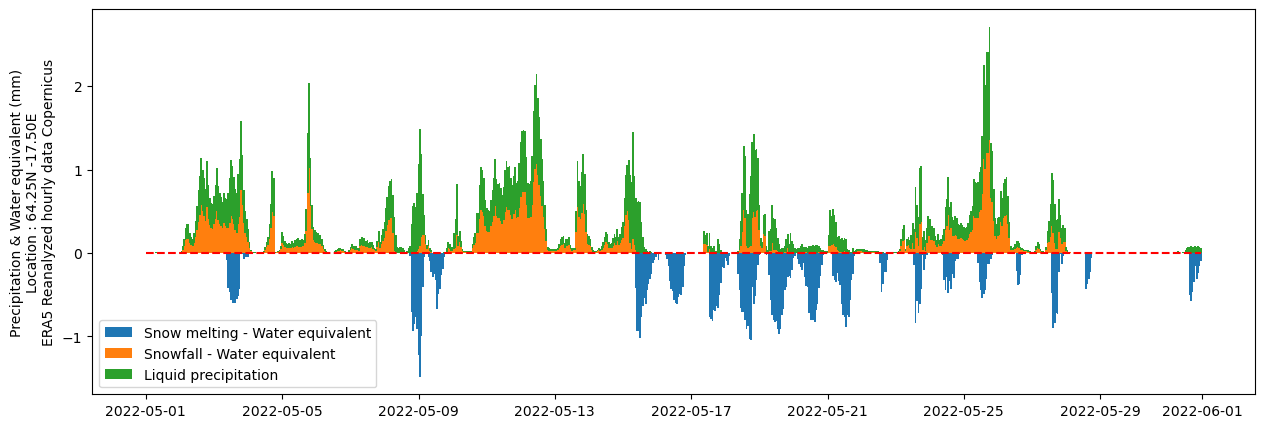

In [34]:
plt.figure(figsize=(15,5))

plt.plot(T, [0]*len(T), c='r', linestyle='--')

plt.bar(T,np.array(SMLT)*-1000, width= 0.05, label='Snow melting - Water equivalent')
plt.bar(T,np.array(SF)*1000, width= 0.05, label='Snowfall - Water equivalent')
plt.bar(T,np.array(PREP)*1000, width= 0.05, bottom = np.array(SF)*1000,label='Liquid precipitation')

plt.ylabel('Precipitation & Water equivalent (mm)\nLocation : %0.2fN %0.2fE\nERA5 Reanalyzed hourly data Copernicus' %(LAT[idxLat], LON[idxLong]))

plt.legend()

plt.show()

### Map plotting

In [35]:
X, Y = np.meshgrid(LON, LAT)

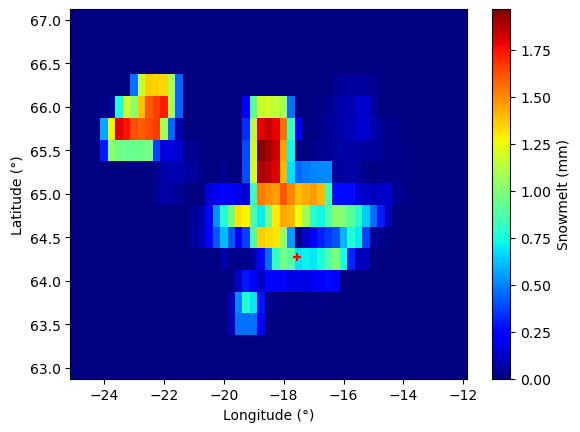

In [42]:
plt.pcolormesh(X,Y,smlt[400]*1000, cmap = 'jet')
plt.colorbar(label='Snowmelt (mm)')
plt.scatter(lon,lat,marker='+', c='r')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.show()